In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [3]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [4]:
def mediapipe_detection(image,model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return image, results

In [5]:
def draw_landmarks(image,results):
    mp_drawing.draw_landmarks(image,results.face_landmarks,mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(0,0,255), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(255,255,255), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=2)
                             ) 

In [6]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    cv2.namedWindow("opencv feed", cv2.WND_PROP_FULLSCREEN)
    cv2.setWindowProperty("opencv feed", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
    
    while cap.isOpened():
        ret,frame= cap.read()
        image,results = mediapipe_detection(frame,holistic)
        print(results)
        draw_landmarks(image,results)
        cv2.imshow("opencv feed",frame)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [7]:
len(results.left_hand_landmarks.landmark)

21

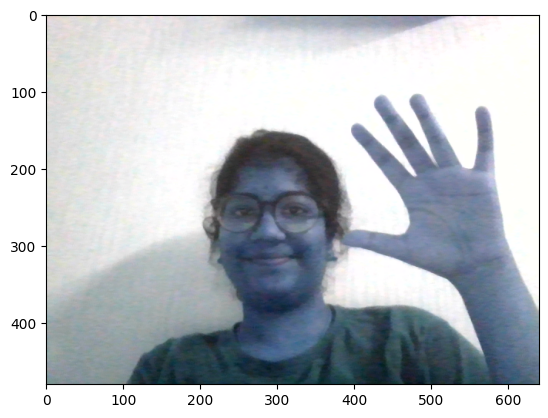

In [8]:
plt.imshow(frame)

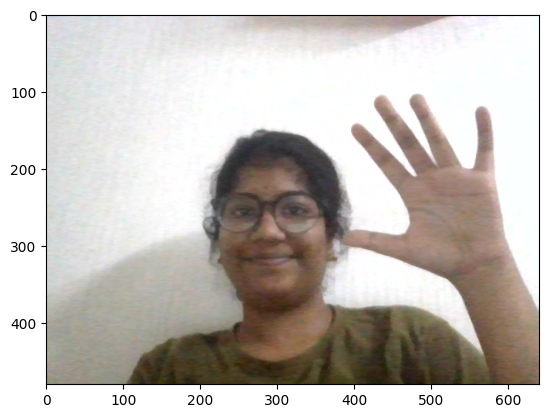

In [9]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [10]:
draw_landmarks(frame,results)

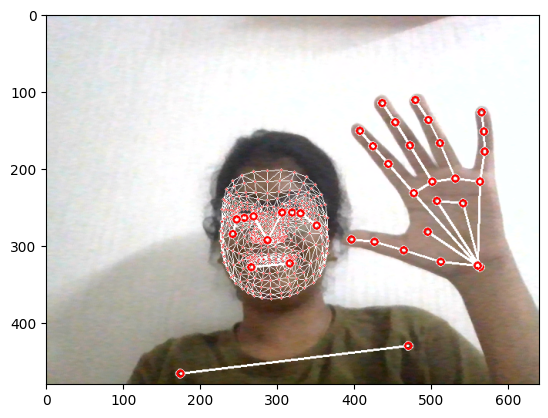

In [11]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [30]:
aks=np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten()
lks=np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten()

In [31]:
aks.shape

(132,)

In [32]:
lks.shape

(63,)

In [33]:
aks


array([ 4.48711336e-01,  6.10924125e-01, -8.62180412e-01,  9.99992967e-01,
        4.79300976e-01,  5.37169695e-01, -7.89439321e-01,  9.99984860e-01,
        4.99757141e-01,  5.36026657e-01, -7.89157152e-01,  9.99987483e-01,
        5.16056180e-01,  5.37987351e-01, -7.88583577e-01,  9.99985397e-01,
        4.21247333e-01,  5.46615601e-01, -7.74314225e-01,  9.99979854e-01,
        4.02530104e-01,  5.50625861e-01, -7.72876024e-01,  9.99976933e-01,
        3.87394011e-01,  5.55348635e-01, -7.72961974e-01,  9.99968588e-01,
        5.49136996e-01,  5.71252286e-01, -4.00042951e-01,  9.99988556e-01,
        3.79015744e-01,  5.94902873e-01, -3.06919873e-01,  9.99977946e-01,
        4.93919313e-01,  6.73993230e-01, -7.24198580e-01,  9.99981821e-01,
        4.16847140e-01,  6.84492469e-01, -7.00184107e-01,  9.99972701e-01,
        7.34440207e-01,  8.96950960e-01, -2.50470251e-01,  9.99378622e-01,
        2.71924675e-01,  9.72703338e-01, -8.20909739e-02,  9.92610216e-01,
        1.01454711e+00,  

In [34]:
lks

array([ 8.75585198e-01,  6.81005061e-01,  4.05860050e-07,  8.01231861e-01,
        6.70073152e-01, -2.27120463e-02,  7.26005435e-01,  6.38848066e-01,
       -3.84955630e-02,  6.66035712e-01,  6.16065145e-01, -5.39796539e-02,
        6.18792057e-01,  6.09062672e-01, -7.03442097e-02,  7.45794535e-01,
        4.83349919e-01, -2.50071809e-02,  6.93814635e-01,  4.04480755e-01,
       -4.82023954e-02,  6.62767053e-01,  3.57232511e-01, -6.73651323e-02,
        6.36222482e-01,  3.15230131e-01, -8.21995884e-02,  7.84352124e-01,
        4.53307390e-01, -3.33647281e-02,  7.38323867e-01,  3.54915023e-01,
       -5.49041815e-02,  7.09021926e-01,  2.93608189e-01, -7.37028122e-02,
        6.82214856e-01,  2.41243660e-01, -8.76561925e-02,  8.30261052e-01,
        4.44320589e-01, -4.54596281e-02,  7.99751878e-01,  3.48955601e-01,
       -7.09248707e-02,  7.75034606e-01,  2.87004769e-01, -8.97650197e-02,
        7.49605834e-01,  2.32963204e-01, -1.02879718e-01,  8.80915940e-01,
        4.53171462e-01, -